In [1]:
from __future__ import print_function
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.7235, 0.9226, 0.1377],
        [0.4451, 0.9527, 0.7840],
        [0.6577, 0.9603, 0.8029],
        [0.1036, 0.2443, 0.9277],
        [0.6600, 0.2773, 0.8147]])


**Set up scVI environment**

In [2]:
def allow_notebook_for_test():
    print("Testing the scVI on pan-fetal macrophages")

import sys, os

n_epochs_all = None
test_mode = False
show_plot = True

def if_not_test_else(x, y):
    if not test_mode:
        return x
    else:
        return y

IN_COLAB = "google.colab" in sys.modules

show_plot = True
test_mode = False
n_epochs_all = None
save_path = "/home/jovyan/Integration/scVI/"

if not test_mode and not IN_COLAB:
    save_path = "/home/jovyan/Integration/scVI/"

**Load required modules**

In [3]:
import anndata
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models import SCANVI, VAE

from umap import UMAP

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

if IN_COLAB:
    %matplotlib inline

# Use GPU
use_cuda = True

/nfs/team292/vl6/miniconda3/envs/scVI_env/lib/python3.8/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)


In [4]:
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 300, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

Running Scanpy 1.6.0, on 2021-04-14 15:39.


In [5]:
%matplotlib inline


**Read in datasets**

In [6]:
path_to_datasets = '/nfs/team292/vl6/liver_label_transfer/'

In [8]:
# Load kidney dataset
kidney = sc.read(path_to_datasets + 'kidney_myeloid.h5ad')
kidney_raw = anndata.AnnData(X=kidney.raw.X, var=kidney.raw.var, obs=kidney.obs)
print(kidney_raw.obs['individual'].value_counts())
print(kidney_raw.obs['sample'].value_counts())
print(kidney_raw.shape)

F3    1479
F6       7
Name: individual, dtype: int64
FCAImmP7462242     1479
4834STDY7002881       7
Name: sample, dtype: int64
(1486, 20127)


In [9]:
# Load liver dataset that has been downsampled to 13 000
liver = sc.read(path_to_datasets + 'liver_myeloid_downsampled.h5ad')
liver_raw = anndata.AnnData(X=liver.raw.X, var=liver.raw.var, obs=liver.obs)
print(liver_raw.obs['individual'].value_counts())
print(liver_raw.obs['sample'].value_counts())
print(liver_raw.shape)

F8     2033
F15    1869
F3     1853
F12    1549
F5     1474
F2     1395
F14     646
F7      641
F10     613
F16     545
F11     382
Name: individual, dtype: int64
FCAImmP7352192    1350
FCAImmP7316894    1102
FCAImmP7555856     982
FCAImmP7462238     930
FCAImmP7462237     923
FCAImmP7555846     887
FCAImmP7528286     865
FCAImmP7316891     692
FCAImmP7528287     684
FCAImmP7316889     676
FCAImmP7316890     665
FCAImmP7179363     646
FCAImmP7198628     641
FCAImmP7198630     613
FCAImmP7277552     545
FCAImmP7579226     382
FCAImmP7316901     293
FCAImmP7352196     124
Name: sample, dtype: int64
(13000, 23422)


In [10]:
# Load skin dataset 
skin = sc.read(path_to_datasets + 'skin_myeloid.h5ad')
skin_raw = anndata.AnnData(X=skin.raw.X, var=skin.raw.var, obs=skin.obs)
print(skin_raw.obs['individual'].value_counts())
print(skin_raw.obs['sample'].value_counts())
print(skin_raw.shape)

F8    3899
F3    2046
F5    1740
F2    1486
F9     147
Name: individual, dtype: int64
FCAImmP7462240    2046
FCAImmP7316886    1994
FCAImmP7316887    1905
FCAImmP7352189    1740
FCAImmP7316896    1486
FCAImmP7241240     147
Name: sample, dtype: int64
(9318, 21781)


In [11]:
# Load yolk sac dataset 
yolksac = sc.read(path_to_datasets + 'yolksac_myeloid.h5ad')
yolksac_raw = anndata.AnnData(X=yolksac.raw.X, var=yolksac.raw.var, obs=yolksac.obs)
print(yolksac_raw.obs['individual'].value_counts())
print(yolksac_raw.obs['sample'].value_counts())
print(yolksac_raw.shape)

F1    8885
F3     166
F2      42
Name: individual, dtype: int64
FCAImmP7504909    2011
FCAImmP7504911    1849
FCAImmP7504910    1756
FCAImmP7504912    1657
FCAImmP7504913    1612
FCAImmP7462244     166
FCAImmP7316900      42
Name: sample, dtype: int64
(9093, 21172)


In [12]:
# Load placenta dataset
placenta = sc.read(path_to_datasets + 'placenta_myeloid.h5ad')
placenta_raw = anndata.AnnData(X=placenta.raw.X, var=placenta.raw.var, obs=placenta.obs)
placenta_raw.obs['individual'] = placenta_raw.obs['Fetus']
print(placenta_raw.obs['individual'].value_counts())
print(placenta_raw.obs['sample'].value_counts())
print(placenta_raw.shape)

F40    1019
F36     714
F25     309
F27     216
F37     182
Name: individual, dtype: int64
FCA7511885    455
FCA7474065    361
FCA7474064    332
FCA7511884    328
FCA7196220    309
FCA7511886    236
FCA7196226    216
FCA7474068    182
FCA7474066     21
Name: sample, dtype: int64
(2440, 23280)


In [13]:
# Load thymus dataset 
thymus = sc.read(path_to_datasets + 'thymus_myeloid.h5ad')
thymus_raw = anndata.AnnData(X=thymus.raw.X, var=thymus.raw.var, obs=thymus.obs)
print(thymus_raw.obs['individual'].value_counts())
print(thymus_raw.obs['sample'].value_counts())
print(thymus_raw.shape)

C40    699
F67    487
F29    369
A16    272
F30    248
C41    235
F64    217
A43    194
F38    190
F21    128
F23    122
F41    105
F22     68
F45     47
C34     35
Name: individual, dtype: int64
WSSS8084742        374
WSSS8084743        325
FCAImmP7277556     231
WSSS8062669        172
FCAImmP7851895     142
FCAImmP7292030     138
FCAImmP7292034     129
FCAImmP7179369     128
FCAImmP7198634     122
FCAImmP7851892     120
FCAImmP7277564     119
WSSS8084745        119
FCAImmP7851890     118
WSSS8084744        116
FCAImmP7851894     114
FCAImmP7851893     111
FCAImmP7851891      99
FCAImmP7528283      98
FCAImmP7528294      92
FCAImmP7198432      68
FCAImmP7555851      61
FCAImmP7555860      44
4861STDY7462261     38
5478STDY7935100     35
4861STDY7462263     35
4861STDY7462264     32
FCAImmP7579230      24
FCAImmP7579218      23
WSSS8062674         22
4861STDY7528592     21
4861STDY7528591     17
4861STDY7528589     17
4861STDY7528588     16
4861STDY7528586     15
4861STDY7462257     15

In [14]:
# Load gonads dataset
gonads = sc.read('/nfs/team292/vl6/immune_fetal_gonads/myeloid_merged.h5ad')
gonads_raw = anndata.AnnData(X=gonads.raw.X, var=gonads.raw.var, obs=gonads.obs)
print(gonads_raw.obs['individual'].value_counts())
print(gonads_raw.obs['sample'].value_counts())
print(gonads_raw.shape)

F88      3446
F83      2616
F93      1645
F96      1431
F94      1313
F86       380
F91       263
F84       263
F99       187
F87       180
Hrv17     170
F122      160
Hrv37     157
Hrv58     157
Hrv41     156
Hrv32     135
Hrv34     130
Hrv25      99
Hrv18      95
Hrv55      67
F133       66
Hrv33      65
Hrv10      65
Hrv3       60
Hrv49      59
Hrv27      46
Hrv40      45
F100       43
F89        37
Hrv15      32
Hrv21      32
Hrv11      31
Hrv31      31
F123       26
Hrv13      25
Hrv30      22
Hrv54      22
Hrv47      21
Hrv59      20
Hrv39      15
Hrv12      12
F126        7
F81         3
Name: individual, dtype: int64
FCA_GND8289579     3446
FCA_GND8103049     2616
FCA_GND8622629     1645
FCA_GND8715407     1431
FCA_GND8622631     1313
FCA_GND8125922      380
FCA_GND8622627      263
FCA_GND8103052      261
FCA_GND8784459      185
FCA_GND8125924      180
FCA_GND8810851      170
FCA_GND9332062      160
HD_F_GON9460408     156
FCA_GND9331966      135
FCA_GND9331970       99
FCA_GND

In [15]:
# Load gut dataset 
gut = sc.read(path_to_datasets + 'gut_myeloid.h5ad')
gut_raw = anndata.AnnData(X=gut.raw.X, var=gut.raw.var, obs=gut.obs)
print(gut_raw.obs['individual'].value_counts())
print(gut_raw.obs['sample'].value_counts())
print(gut_raw.shape)

9.0    510
8.0    435
2.0    241
6.0    146
3.0    124
1.0     91
5.0     66
7.0     28
4.0      1
Name: individual, dtype: int64
4918STDY7317585    170
4918STDY7718973    128
4918STDY7717788    119
4918STDY7717787    119
4918STDY7718975    115
4918STDY7717783    112
4918STDY7693763     90
4918STDY7718974     83
4918STDY7718972     79
4918STDY7718976     60
4918STDY7421297     57
4918STDY7321515     56
4918STDY7421298     55
4918STDY7426908     46
4918STDY7718977     45
4918STDY7317587     40
4918STDY7717784     32
4918STDY7317586     31
4918STDY7717785     28
4918STDY7693758     25
4918STDY7717789     25
4918STDY7426907     20
4918STDY7321513     20
4918STDY7693760     20
4918STDY7693757     16
4918STDY7693759     15
4918STDY7321514     15
4918STDY7421299     12
4918STDY7693761      6
4918STDY7693762      2
4918STDY7426906      1
Name: sample, dtype: int64
(1642, 24079)


**Concatenate datasets**

In [16]:
all_tissues = liver_raw.concatenate(kidney_raw, yolksac_raw, gonads_raw, skin_raw, gut_raw, placenta_raw, thymus_raw, 
                                  batch_key = 'tissue', 
                                batch_categories = ['liver', 'kidney', 'yolksac', 'gonad', 'skin', 'gut', 'placenta', 'thymus'], 
                                  join = 'outer')
all_tissues.shape

(54230, 29886)

In [18]:
all_tissues.obs['individual'] = all_tissues.obs['individual'].astype('str')
all_tissues.obs['individual'] = all_tissues.obs['individual'].astype('category')

all_tissues.obs['individual'].cat.categories

Index(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', 'A16',
       'A43', 'C34', 'C40', 'C41', 'F1', 'F10', 'F100', 'F11', 'F12', 'F122',
       'F123', 'F126', 'F133', 'F14', 'F15', 'F16', 'F2', 'F21', 'F22', 'F23',
       'F25', 'F27', 'F29', 'F3', 'F30', 'F36', 'F37', 'F38', 'F40', 'F41',
       'F45', 'F5', 'F6', 'F64', 'F67', 'F7', 'F8', 'F81', 'F83', 'F84', 'F86',
       'F87', 'F88', 'F89', 'F9', 'F91', 'F93', 'F94', 'F96', 'F99', 'Hrv10',
       'Hrv11', 'Hrv12', 'Hrv13', 'Hrv15', 'Hrv17', 'Hrv18', 'Hrv21', 'Hrv25',
       'Hrv27', 'Hrv3', 'Hrv30', 'Hrv31', 'Hrv32', 'Hrv33', 'Hrv34', 'Hrv37',
       'Hrv39', 'Hrv40', 'Hrv41', 'Hrv47', 'Hrv49', 'Hrv54', 'Hrv55', 'Hrv58',
       'Hrv59'],
      dtype='object')

In [19]:
all_tissues.obs['sample'] = all_tissues.obs['sample'].astype('category')
all_tissues.obs['sample'].cat.categories


Index(['4834STDY7002881', '4861STDY7462257', '4861STDY7462258',
       '4861STDY7462259', '4861STDY7462260', '4861STDY7462261',
       '4861STDY7462262', '4861STDY7462263', '4861STDY7462264',
       '4861STDY7528585',
       ...
       'HD_F_GON9883863', 'HD_F_GON9883866', 'HD_F_GON9883867',
       'HD_F_GON9883868', 'WSSS8062669', 'WSSS8062674', 'WSSS8084742',
       'WSSS8084743', 'WSSS8084744', 'WSSS8084745'],
      dtype='object', length=170)

**Create combined individual+sample index for batch correction**

In [20]:
all_tissues.obs['combined'] = [all_tissues.obs.loc[i,'sample'] + all_tissues.obs.loc[i,'individual'] for i in all_tissues.obs_names]
pd.set_option('display.max_rows', 500)
all_tissues.obs['combined'].value_counts(dropna = False)

FCA_GND8289579F88       3446
FCA_GND8103049F83       2616
FCAImmP7462240F3        2046
FCAImmP7504909F1        2011
FCAImmP7316886F8        1994
FCAImmP7316887F8        1905
FCAImmP7504911F1        1849
FCAImmP7504910F1        1756
FCAImmP7352189F5        1740
FCAImmP7504912F1        1657
FCA_GND8622629F93       1645
FCAImmP7504913F1        1612
FCAImmP7316896F2        1486
FCAImmP7462242F3        1479
FCA_GND8715407F96       1431
FCAImmP7352192F5        1350
FCA_GND8622631F94       1313
FCAImmP7316894F2        1102
FCAImmP7555856F15        982
FCAImmP7462238F3         930
FCAImmP7462237F3         923
FCAImmP7555846F15        887
FCAImmP7528286F12        865
FCAImmP7316891F8         692
FCAImmP7528287F12        684
FCAImmP7316889F8         676
FCAImmP7316890F8         665
FCAImmP7179363F14        646
FCAImmP7198628F7         641
FCAImmP7198630F10        613
FCAImmP7277552F16        545
FCA7511885F40            455
FCAImmP7579226F11        382
FCA_GND8125922F86        380
WSSS8084742C40

**Preprocess the whole dataset**

In [21]:
all_tissues_raw = all_tissues.copy()
sc.pp.normalize_per_cell(all_tissues, counts_per_cell_after = 1e4)
sc.pp.log1p(all_tissues)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [22]:
sc.pp.filter_genes(all_tissues, min_counts=3)

filtered out 7456 genes that are detected in less than 3 counts


**Process separate datasets in a way that scVI likes**

In [24]:
# LIVER
liver_raw.X = liver_raw.X.astype('int')
liver_raw = AnnDatasetFromAnnData(ad = liver_raw)
print(liver_raw)

[2021-04-14 15:40:45,730] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-14 15:40:45,732] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-14 15:40:46,341] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:40:46,524] INFO - scvi.dataset.dataset | Downsampled from 13000 to 13000 cells
GeneExpressionDataset object with n_cells x nb_genes = 13000 x 23422
    gene_attribute_names: 'n_cells', 'gene_names', 'feature_types-6', 'n_cells-13', 'gene_ids-10', 'gene_ids-16', 'gene_ids-12', 'gene_ids-4', 'feature_types-3', 'feature_types-0', 'n_cells-10', 'n_cells-11', 'n_cells-5', 'n_cells-0', 'gene_ids-5', 'n_cells-14', 'feature_types-2', 'gene_ids-15', 'feature_types-10', 'gene_ids-9', 'feature_types-5', 'gene_ids-1', 'feature_types-14', 'n_cells-16', 'gene_ids-3', 'feature_types-16', 'n_cells-7', 'feature_types-11', 'gene_ids-7', 'n_cells-2', 'feature_types-9', 'gene_ids-11', 'n_cells-6', 'feature_types-13', 'featur

In [25]:
# KIDNEY
kidney_raw.X = kidney_raw.X.astype('int')
kidney_raw = AnnDatasetFromAnnData(ad = kidney_raw)
print(kidney_raw)

[2021-04-14 15:40:46,555] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2021-04-14 15:40:46,798] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-14 15:40:46,800] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-14 15:40:47,066] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:40:47,116] INFO - scvi.dataset.dataset | Downsampled from 1486 to 1486 cells
GeneExpressionDataset object with n_cells x nb_genes = 1486 x 20127
    gene_attribute_names: 'n_cells', 'n_cells-0', 'gene_names', 'gene_ids-1', 'n_cells-1', 'feature_types-0', 'feature_types-1', 'gene_ids-0'
    cell_attribute_names: 'percent_mito', 'individual', 'labels', 'clinical_info', 'scrublet_score', 'phase', 'local_means', 'n_genes', 'bh_pval', 'is_doublet', 'Run', 'tissue', 'scrublet_cluster_score', 'bonf_pval', 'zscore', 'doublet_score', 'local_vars', 'G2M_score', 'doublet_score_0.75', 'S_score', 'Run

In [26]:
# SKIN

skin_raw.X = skin_raw.X.astype('int')
skin_raw = AnnDatasetFromAnnData(ad = skin_raw)
print(skin_raw)

[2021-04-14 15:40:47,423] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-14 15:40:47,426] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-14 15:40:47,724] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:40:47,804] INFO - scvi.dataset.dataset | Downsampled from 9318 to 9318 cells
GeneExpressionDataset object with n_cells x nb_genes = 9318 x 21781
    gene_attribute_names: 'n_cells', 'gene_names', 'gene_ids-4', 'feature_types-3', 'feature_types-0', 'n_cells-5', 'n_cells-0', 'gene_ids-5', 'feature_types-2', 'feature_types-5', 'gene_ids-1', 'gene_ids-3', 'n_cells-2', 'feature_types-4', 'n_cells-4', 'n_cells-3', 'n_cells-1', 'gene_ids-2', 'feature_types-1', 'gene_ids-0'
    cell_attribute_names: 'percent_mito', 'individual', 'labels', 'clinical_info', 'scrublet_score', 'phase', 'local_means', 'n_genes', 'bh_pval', 'is_doublet', 'Run', 'tissue', 'scrublet_cluster_score', 'bonf_pval', 'zscore', 'doublet_score',

In [27]:
# YOLK SAC

yolksac_raw.X = yolksac_raw.X.astype('int')
yolksac_raw = AnnDatasetFromAnnData(ad = yolksac_raw)
print(yolksac_raw)

[2021-04-14 15:40:48,139] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-14 15:40:48,141] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-14 15:40:48,459] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:40:48,548] INFO - scvi.dataset.dataset | Downsampled from 9093 to 9093 cells
GeneExpressionDataset object with n_cells x nb_genes = 9093 x 21172
    gene_attribute_names: 'n_cells', 'gene_names', 'feature_types-6', 'gene_ids-4', 'feature_types-3', 'feature_types-0', 'n_cells-5', 'n_cells-0', 'gene_ids-5', 'feature_types-2', 'feature_types-5', 'gene_ids-1', 'gene_ids-3', 'n_cells-2', 'n_cells-6', 'feature_types-4', 'n_cells-4', 'n_cells-3', 'n_cells-1', 'gene_ids-2', 'feature_types-1', 'gene_ids-0', 'gene_ids-6'
    cell_attribute_names: 'percent_mito', 'individual', 'labels', 'clinical_info', 'scrublet_score', 'phase', 'local_means', 'n_genes', 'bh_pval', 'is_doublet', 'Run', 'tissue', 'scrublet_cluster_s

In [28]:
# GONADS

gonads_raw.X = gonads_raw.X.astype('int')
gonads_raw = AnnDatasetFromAnnData(ad = gonads_raw)
print(gonads_raw)

[2021-04-14 15:40:51,174] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-14 15:40:51,177] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-14 15:40:51,621] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:40:51,740] INFO - scvi.dataset.dataset | Downsampled from 13835 to 13835 cells
GeneExpressionDataset object with n_cells x nb_genes = 13835 x 28497
    gene_attribute_names: 'n_cells-1-0', 'gene_ids-28-1', 'feature_types-8-0', 'gene_ids-6-1', 'n_cells-46-1', 'feature_types-5-0', 'gene_ids-9-1', 'n_cells-21-1', 'gene_ids-25-1', 'n_cells-31-1', 'gene_ids-2-0', 'feature_types-43-1', 'gene_ids-3-0', 'feature_types-24-1', 'n_cells-0-1', 'gene_ids-13-1', 'n_cells-38-1', 'n_cells-51-1', 'n_cells-6-1', 'gene_ids-43-1', 'n_cells-13-1', 'gene_ids-19-1', 'gene_ids-0-0', 'gene_ids-10-1', 'n_cells-25-1', 'gene_ids-44-1', 'feature_types-4-1', 'n_cells-3-0', 'n_cells-3-1', 'feature_types-3-0', 'gene_ids-23-1', 'n_cells-

In [29]:
# THYMUS

thymus_raw.X = thymus_raw.X.astype('int')
thymus_raw = AnnDatasetFromAnnData(ad = thymus_raw)
print(thymus_raw)

[2021-04-14 15:40:51,827] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2021-04-14 15:40:52,790] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-14 15:40:52,793] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-14 15:40:53,636] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:40:53,778] INFO - scvi.dataset.dataset | Downsampled from 3416 to 3416 cells
GeneExpressionDataset object with n_cells x nb_genes = 3416 x 25480
    gene_attribute_names: 'feature_types-6', 'gene_ids-37', 'gene_ids-25', 'n_cells-10', 'n_cells-11', 'gene_ids-27', 'feature_types-40', 'feature_types-2', 'n_cells-23', 'gene_ids-3', 'feature_types-25', 'n_cells-2', 'gene_ids-11', 'n_cells-21', 'n_cells-6', 'n_cells-15', 'gene_ids-20', 'n_cells-4', 'feature_types-36', 'gene_ids-13', 'feature_types-35', 'feature_types-31', 'n_cells-12', 'gene_ids-14', 'feature_types-1', 'feature_types-16', 'feat

In [30]:
# PLACENTA

placenta_raw.X = placenta_raw.X.astype('int')
placenta_raw = AnnDatasetFromAnnData(ad = placenta_raw)
print(placenta_raw)

[2021-04-14 15:40:53,847] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2021-04-14 15:40:54,329] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-14 15:40:54,331] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-14 15:40:54,906] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:40:55,003] INFO - scvi.dataset.dataset | Downsampled from 2440 to 2440 cells
GeneExpressionDataset object with n_cells x nb_genes = 2440 x 23280
    gene_attribute_names: 'n_cells', 'gene_names', 'feature_types-6', 'gene_ids-4', 'feature_types-3', 'feature_types-0', 'n_cells-5', 'n_cells-0', 'gene_ids-5', 'feature_types-2', 'gene_ids-9', 'feature_types-5', 'gene_ids-1', 'gene_ids-3', 'n_cells-7', 'gene_ids-7', 'n_cells-2', 'feature_types-9', 'n_cells-6', 'feature_types-4', 'gene_ids-8', 'n_cells-4', 'n_cells-3', 'n_cells-9', 'n_cells-1', 'gene_ids-2', 'feature_types-7', 'n_cells-8', 'feat

In [31]:
# GUT 

gut_raw.X = gut_raw.X.astype('int')
gut_raw = AnnDatasetFromAnnData(ad = gut_raw)
print(gut_raw)

[2021-04-14 15:40:55,046] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2021-04-14 15:40:55,614] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-14 15:40:55,616] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-14 15:40:55,992] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:40:56,060] INFO - scvi.dataset.dataset | Downsampled from 1642 to 1642 cells
GeneExpressionDataset object with n_cells x nb_genes = 1642 x 24079
    gene_attribute_names: 'feature_types-6', 'gene_ids-25', 'n_cells-10', 'n_cells-11', 'gene_ids-27', 'feature_types-2', 'n_cells-23', 'gene_ids-3', 'feature_types-25', 'n_cells-2', 'gene_ids-11', 'n_cells-21', 'n_cells-6', 'n_cells-15', 'gene_ids-20', 'n_cells-4', 'gene_ids-13', 'feature_types-31', 'n_cells-12', 'gene_ids-14', 'feature_types-1', 'feature_types-16', 'feature_types-26', 'gene_names', 'gene_ids-16', 'feature_types-22', 'n_cells-25

In [32]:
macro_multi = GeneExpressionDataset()
macro_multi.populate_from_datasets([liver_raw, kidney_raw, yolksac_raw, gonads_raw, skin_raw, gut_raw, placenta_raw, thymus_raw])


[2021-04-14 15:40:56,092] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-04-14 15:40:56,097] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-04-14 15:40:56,234] INFO - scvi.dataset.dataset | Keeping 18119 genes
[2021-04-14 15:40:56,915] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:40:57,103] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-14 15:40:57,105] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-14 15:40:57,406] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:40:57,509] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-14 15:40:57,511] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-14 15:40:57,877] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-14 15:

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
macro_multi.batch_indices = le.fit_transform(all_tissues.obs['combined'])[:, None]

In [34]:
macro_multi.n_batches


170

In [35]:
macro_multi.n_labels


1

In [36]:
macro_multi.batch_indices


array([[58],
       [58],
       [58],
       ...,
       [ 1],
       [ 1],
       [ 1]], dtype=uint16)

**Define scVI model**

In [37]:
vae = VAE(macro_multi.nb_genes, n_batch = macro_multi.n_batches, n_labels = macro_multi.n_labels,
          n_hidden = 128, n_latent = 55, n_layers = 3, dispersion = 'gene-batch', reconstruction_loss = 'nb')

**Train the model**

In [38]:
trainer = UnsupervisedTrainer(vae, macro_multi, train_size = 0.9)
n_epochs = 200
trainer.train(n_epochs = n_epochs)

[2021-04-14 15:41:11,744] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2021-04-14 15:41:11,747] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████| 200/200 [25:17<00:00,  7.59s/it]
[2021-04-14 16:06:28,991] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


**Extract latent space from posterior object**

In [39]:
full = trainer.create_posterior(trainer.model, macro_multi, indices = np.arange(len(macro_multi)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()


**Visualize latent space with UMAP**

In [40]:
latent_u = UMAP(spread = 2).fit_transform(latent)


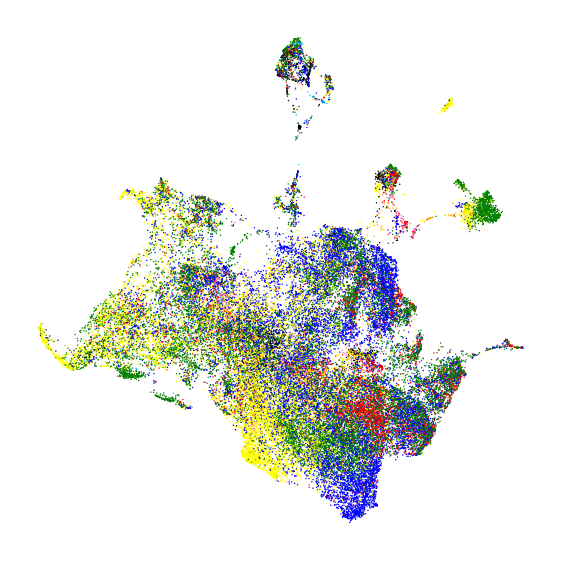

In [41]:
cm = LinearSegmentedColormap.from_list(
        'my_cm', ['deepskyblue', 'hotpink', 'red', 'green', 'blue', 'yellow', 'orange', 'black'], N = 8) #change here with my number of batches 
fig, ax = plt.subplots(figsize = (4, 4))
order = np.arange(latent.shape[0])
random.shuffle(order)
ax.scatter(latent_u[order, 0], latent_u[order, 1],
           c = macro_multi.batch_indices.ravel()[order],
           cmap = cm, edgecolors = 'none', s = 0.5)
plt.axis("off")
fig.set_tight_layout(True)

In [42]:
adata_latent = sc.AnnData(latent)
adata_latent.obs = all_tissues.obs
sc.pp.neighbors(adata_latent, use_rep = 'X', n_neighbors = 15, metric = 'minkowski')


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [43]:
sc.tl.umap(adata_latent, min_dist = 0.04, spread = 1, random_state = 1712)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:48)


... storing 'batch' as categorical
... storing 'clinical_info' as categorical
... storing 'facs' as categorical
... storing 'sex' as categorical
... storing 'stage' as categorical
... storing 'cell_type' as categorical
... storing 'doublet_score_0.75' as categorical
... storing 'leiden' as categorical
... storing 'batch_collection' as categorical
... storing 'cryopreserved' as categorical
... storing 'location' as categorical
... storing 'process' as categorical
... storing 'study' as categorical
... storing 'sample_source' as categorical
... storing 'enrichment' as categorical
... storing '5v1.1' as categorical
... storing 'TP' as categorical
... storing 'clusters' as categorical
... storing 'clusters_manual' as categorical
... storing 'liver_classifier' as categorical
... storing 'lineages' as categorical
... storing 'Enrichment strategy' as categorical
... storing 'purification' as categorical
... storing 'Description' as categorical
... storing 'Fetus' as categorical
... storing 'S

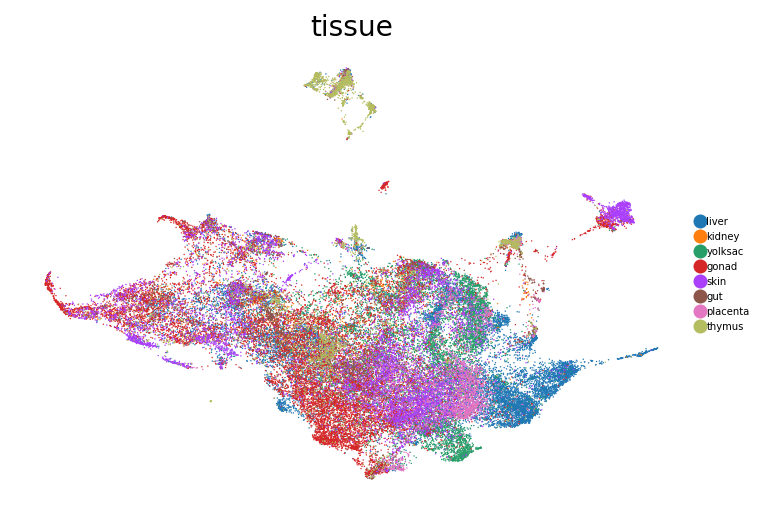

In [44]:
sc.pl.umap(adata_latent, frameon = False, color = ['tissue'], size = 2, legend_fontsize = 5, ncols = 1)

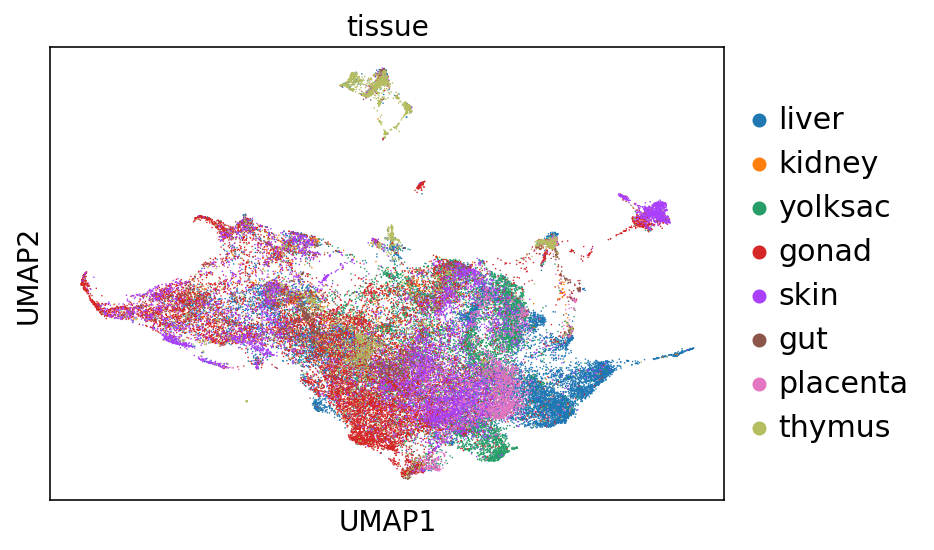

In [45]:
sc.pl.umap(adata_latent, frameon = True, color = ['tissue'], size = 2.4, legend_fontsize = 15, ncols = 1)

In [46]:
adata_latent.raw = all_tissues.copy()
adata_latent

AnnData object with n_obs × n_vars = 54230 × 55
    obs: 'Run', 'Run2', 'StudyID', 'batch', 'clinical_info', 'facs', 'individual', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sex', 'stage', 'tissue', 'S_score', 'G2M_score', 'phase', 'cell_type', 'doublet_score', 'doublet_score_0.75', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'leiden', 'batch_collection', 'cryopreserved', 'location', 'process', 'study', 'PCW', 'sample_source', 'enrichment', '5v1.1', 'TP', 'clusters', 'louvain', 'clusters_manual', 'liver_classifier', 'prob_B cell', 'prob_DC1', 'prob_DC2', 'prob_Early lymphoid/T lymphocyte', 'prob_Erythroblastic Island Macrophage', 'prob_HSC/MPP', 'prob_ILC precursor', 'prob_Kupffer Cell', 'prob_MEMP', 'prob_Mast cell', 'prob_Megakaryocyte', 'prob_Mono-Mac', 'prob_Mono-NK', 'prob_Monocyte', 'prob_Monocyte-DC precursor', 'prob_NK', 'prob_Neutrophil-myeloid progenitor', 'prob_VCAM1+ Erythroblastic Island Macrophage', 'prob_pDC precurso

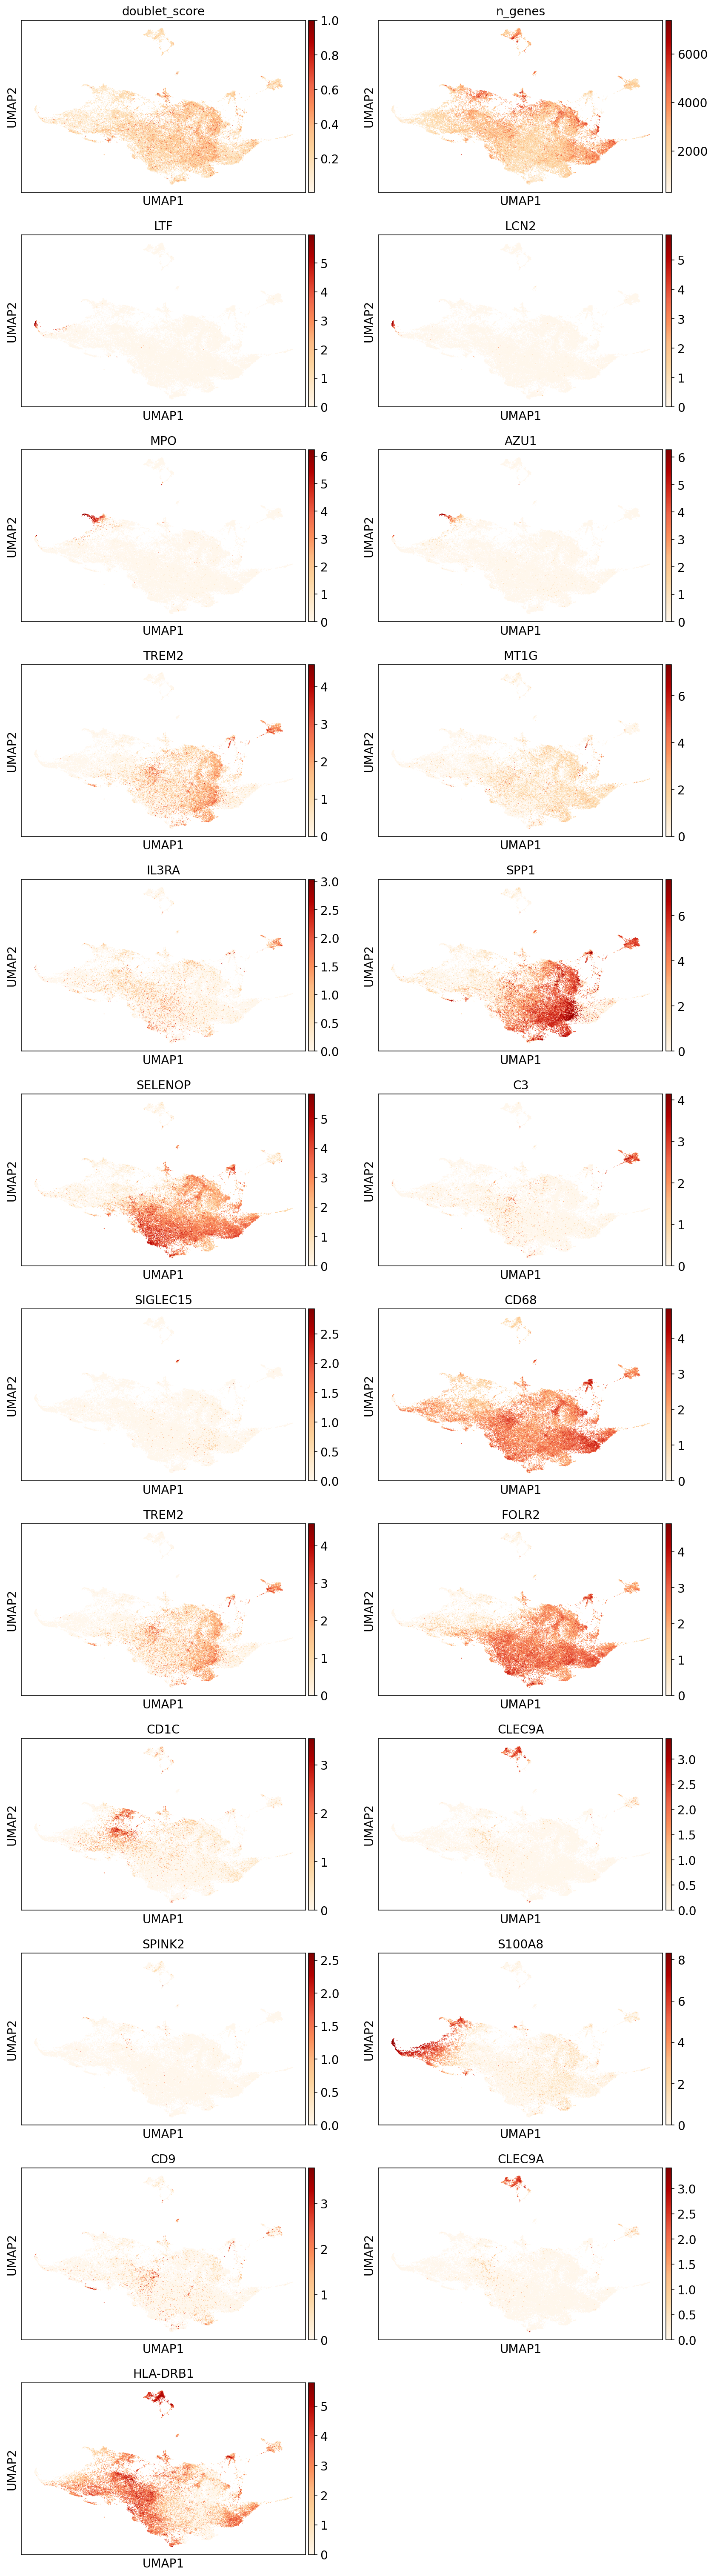

In [47]:
sc.pl.umap(adata_latent, frameon = True, color = ['doublet_score', 'n_genes', 'LTF', 'LCN2', 'MPO', 'AZU1', 'TREM2', 'MT1G', 'IL3RA', 'SPP1', 'SELENOP', 'C3', 'SIGLEC15', 'CD68', 'TREM2', 'FOLR2', 'CD1C', 'CLEC9A',
                                                 'SPINK2', 'S100A8', 'CD9', 'CLEC9A', 'HLA-DRB1'], color_map = 'OrRd', ncols = 2)

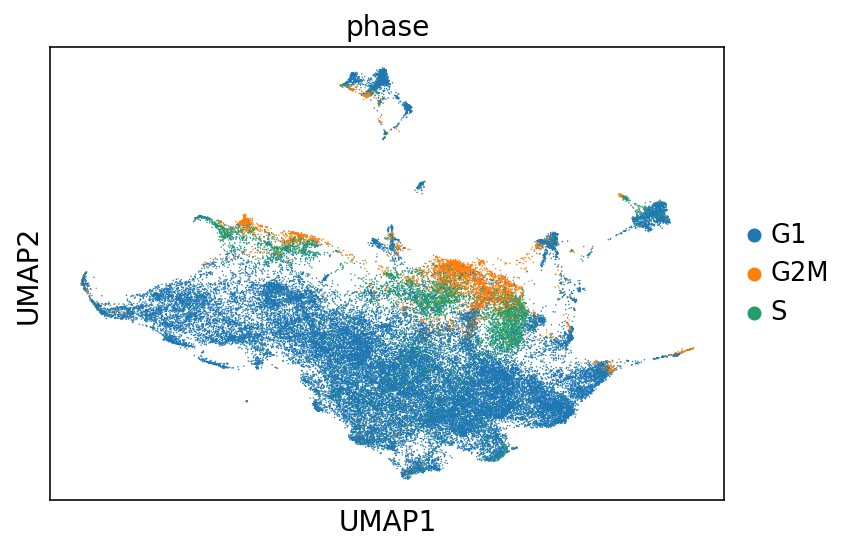

In [48]:

sc.pl.umap(adata_latent, color = ['phase'])

In [51]:
adata_latent.write('/nfs/team292/vl6/liver_label_transfer/fetal_myeloid_atlas_scVI_noLung.h5ad')

#### End of notebook